In [38]:
%matplotlib inline

In [39]:
import re
import os
job_ids = [re.search('(\d){7}', dir).group() for dir in os.listdir("./shared/NORTH/") if re.search('data_(\d){7}', dir)]
job_ids.sort()
# The last (highest id) job id is the lates job
job_id = job_ids[-1]

In [40]:
import numpy as np
from matplotlib import pyplot as plt
from boutdata import collect
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from boutdata.data import BoutData

path        = './shared/NORTH/data_' + job_id + '/'
bdata = BoutData(path)
outputs = bdata['outputs']
options  =bdata['options']

field_keys = bdata['outputs'].keys()

/home/niflheim/s173965/venv/lib/python3.8/site-packages/boutdata/data.py:732: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: name 'mxg' is not defined
Evaluating non-scalar options not available
  alwayswarn(


In [41]:
def get_CLI_option(job_id, key):
    for i, line in enumerate(open('./shared/NORTH/slurm_out/north_full_' + job_id + '_ESEL.log', 'r')):
        match = re.search('Command line options for this run.*' + key + '\s*\=\s*(\S*)', line)
        if match:
            try:
                return eval(match.group(1))
            except:
                return match.group(1)

def get_option(*keys):
    cli_option = get_CLI_option(job_id, keys[-1])
    if cli_option == None:
        from numpy import sqrt, pi
        from ast import parse, walk, Name
        val = options
        group = keys[0]
        for key in keys:
            val = val[key]
        try:
            return eval(str(val))
        except:
            # Parse undefined variables from the Bout.inp file:
            val_str = str(val).replace(':', '____') # Replace group indicator ':' with '____' to make string parsable.
            for node in walk(parse(val_str)):
                if type(node) is Name:
                    missing_keys = node.id.split('____')
                    var = missing_keys[-1]
                    if var not in locals():
                        try:
                            locals()[var] = get_option(*missing_keys)
                        except:
                            missing_keys.insert(0, group)
                            try:
                                locals()[var] = get_option(*missing_keys)
                            except:
                                print('Error reading option for keys: ', keys)
                                return 0
            return eval(str(val))
    else:
        return cli_option

def get_options(keys_list):
    vals = []
    for keys in keys_list:
        vals.append(get_option(*keys))
    return vals

In [42]:
oci, rho_s, R, n0, Te0, mxg, myg, nx_all, ny_all, nz_all = get_options([
    ('north', 'oci'), ('north', 'rho_s'), ('north', 'R'),
    ('north', 'n0'), ('north', 'Te0'),
    ('mxg',), ('myg',),
    ('mesh', 'nx'),('mesh', 'ny'),('mesh', 'nz')])
Lx = R/rho_s * rho_s
nx_inner = nx_all - 2*mxg
ny_inner = ny_all - 2*myg
nz_inner = nz_all

**Strength of vorticity Sink**

In [43]:
try:
    vort_sink_strength = get_option('north', 'vort_sink_strength')
except:
    if job_id == '5347831' or job_id == '5352599':
        vort_sink_strength = 0.1
    else:
        print('unknown vorticity sink strength')
print('vorticity sink strength: ' + str(vort_sink_strength))

vorticity sink strength: 10


In [44]:
#%% Read data

field_list  = ['T', 'n', 'phi', 'vort', 'source_T','wall_shadow']
par_list    = ['t_array']
# fast_list   = ['t_array', 'n0', 'phi0', 'n1', 'phi1', 'n2', 'phi2', 'T0', 'T1', 'T2']
#%%
data, par, fast = {}, {}, {}

for _field in field_list:
    data[_field] = collect(_field, path = path, xguards = False)

for _par in par_list:
    par[_par] = collect(_par, path = path, xguards = False)

mxsub = 2 mysub = 1 mz = 128

nxpe = 24, nype = 1, npes = 24

Reading from 0: [2-3][0-0] -> [0-1][0-0]

Reading from 1: [2-3][0-0] -> [2-3][0-0]

Reading from 2: [2-3][0-0] -> [4-5][0-0]

Reading from 3: [2-3][0-0] -> [6-7][0-0]

Reading from 4: [2-3][0-0] -> [8-9][0-0]

Reading from 5: [2-3][0-0] -> [10-11][0-0]

Reading from 6: [2-3][0-0] -> [12-13][0-0]

Reading from 7: [2-3][0-0] -> [14-15][0-0]

Reading from 8: [2-3][0-0] -> [16-17][0-0]

Reading from 9: [2-3][0-0] -> [18-19][0-0]

Reading from 10: [2-3][0-0] -> [20-21][0-0]

Reading from 11: [2-3][0-0] -> [22-23][0-0]

Reading from 12: [2-3][0-0] -> [24-25][0-0]

Reading from 13: [2-3][0-0] -> [26-27][0-0]

Reading from 14: [2-3][0-0] -> [28-29][0-0]

Reading from 15: [2-3][0-0] -> [30-31][0-0]

Reading from 16: [2-3][0-0] -> [32-33][0-0]

Reading from 17: [2-3][0-0] -> [34-35][0-0]

Reading from 18: [2-3][0-0] -> [36-37][0-0]

Reading from 19: [2-3][0-0] -> [38-39][0-0]

Reading from 20: [2-3][0-0] -> [40-41][0-0]

Reading from 

In [45]:
thetas = np.linspace(0, 2 * np.pi, nz_inner)
rhos = np.linspace(Lx/(2*nx_inner), Lx+Lx/(2*nx_inner), nx_inner)
t = par['t_array']/oci

### Mean Density

In [46]:
n_mean = np.mean(np.mean(data['n'].squeeze(),axis=1), axis=1)

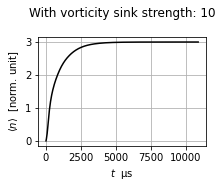

In [47]:
plt.figure(figsize=(3,2))
plt.plot(t*(10**6),n_mean, 'k-')
plt.xlabel(r'$t$  $\mathrm{\mu s}$')
plt.ylabel(r'$\left<n\right>$  [norm. unit]')
plt.grid()
plt.title('With vorticity sink strength: ' + str(vort_sink_strength), pad=20)
plt.savefig('plots/' + job_id + 'density_vs_time.png')

### Contained Energy

In [48]:
mesh_t, mesh_rhos, mesh_thetas = np.meshgrid(t, rhos, thetas, indexing='ij')

Jfun = lambda t, r, theta: np.abs(r*(R + r*np.cos(theta)))
def energy():
    n = data['n'].squeeze()*n0
    T = data['T'].squeeze()*Te0
    J = Jfun(mesh_t, mesh_rhos, mesh_thetas)
    return 2*np.pi*np.trapz(np.trapz(J*((3/2)*n*T), rhos, axis=1), thetas, axis=1)

E = energy()

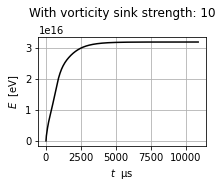

In [49]:
plt.figure(figsize=(3,2))
plt.plot(t*(10**6), E, 'k-')
plt.xlabel(r'$t$  $\mathrm{\mu s}$')
plt.ylabel(r'$E$  $\mathrm{[eV]}$')
plt.grid()
plt.title('With vorticity sink strength: ' + str(vort_sink_strength), pad=20)
plt.savefig('plots/' + job_id + '_energy.png')

In [50]:
# Method to change the contour data points
def plot_field(field, i, cmap='inferno'):
    vmin = data[field].min()
    vmax = data[field].max()
    # ax.clear()
    contour_set = ax.contourf(thetas, rhos, data[field][i, :, :, :].squeeze(), 100, cmap = cmap, vmin=vmin, vmax=vmax)
    ax.set_rticks([])
    ax.set_xticks([])
    fig.tight_layout()
    return contour_set

def animate_n(i):
    plot_field('n',i)
def animate_T(i):
    plot_field('T',i)
def animate_vort(i):
    plot_field('vort',i, cmap='jet')

In [56]:
import matplotlib.animation as animation

def animate_data(field, cmap='inferno', vmin = None, vmax = None):
    field_data = data[field].squeeze()
    if vmin is None:
        vmin = field_data.min()
    if vmax is None:
        vmax = field_data.max()
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    fig.suptitle('With vorticity sink strength: ' + str(vort_sink_strength))
    
    ax.set_rticks([])
    ax.set_xticks([])
    cont = ax.contourf(thetas, rhos, field_data[0, :, :], 100, cmap = cmap, vmin=vmin, vmax=vmax)    # first image on screen
    fig.colorbar(cont, ax=ax)
    fig.tight_layout()

    # animation function
    def animate(i):
        for c in ax.collections:
            c.remove()  # removes only the contours, leaves the rest intact
        cont = ax.contourf(thetas, rhos, field_data[i, :, :], 100, cmap = cmap, vmin=vmin, vmax=vmax)
        return cont.collections
    
    anim = animation.FuncAnimation(fig, animate, frames=field_data.shape[0], interval=100, blit=True)
    anim.save('./plots/' + job_id + '_animation_' + field +'.gif', fps=4)
    plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


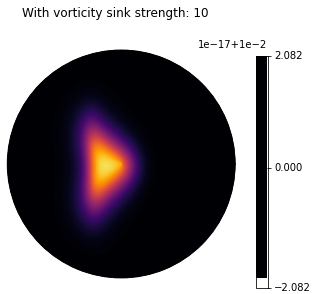

In [57]:
animate_data('n')

MovieWriter ffmpeg unavailable; using Pillow instead.


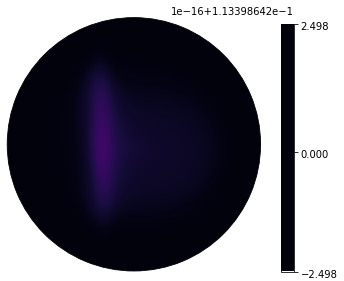

In [55]:
animate_data('T', vmin=0, vmax=5)

In [ ]:
animate_data('vort', cmap='jet')

In [ ]:
animate_data('phi', cmap='jet')